# Bulldozer Price Regression Model

## Import Required Libraries

In this section, we import all necessary libraries for:
- **Data manipulation**: pandas, numpy
- **Machine learning pipeline**: sklearn components for preprocessing, modeling, and evaluation
- **Model**: RandomForestRegressor for regression tasks
- **Preprocessing**: ColumnTransformer, SimpleImputer, OrdinalEncoder, FunctionTransformer
- **Evaluation**: mean_absolute_error, root_mean_squared_log_error

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# Import and prepare data
train_df = pd.read_csv("Train.csv",
                       parse_dates=["saledate"],
                       low_memory=False).sort_values(by="saledate", ascending=True)

valid_df = pd.read_csv("Valid.csv",
                       parse_dates=["saledate"])

valid_solution = pd.read_csv("ValidSolution.csv")
valid_df["SalePrice"] = valid_df["SalesID"].map(valid_solution.set_index("SalesID")["SalePrice"])
valid_df = valid_df.sort_values("saledate", ascending=True).reset_index(drop=True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 400217
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

In [5]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11573 entries, 0 to 11572
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   11573 non-null  int64         
 1   MachineID                 11573 non-null  int64         
 2   ModelID                   11573 non-null  int64         
 3   datasource                11573 non-null  int64         
 4   auctioneerID              11573 non-null  int64         
 5   YearMade                  11573 non-null  int64         
 6   MachineHoursCurrentMeter  4739 non-null   float64       
 7   UsageBand                 4031 non-null   object        
 8   saledate                  11573 non-null  datetime64[ns]
 9   fiModelDesc               11573 non-null  object        
 10  fiBaseModel               11573 non-null  object        
 11  fiSecondaryDesc           8037 non-null   object        
 12  fiModelSeries     

In [6]:
# Add datetime features
def add_datetime_features_to_df(df, date_column="saledate"):
    df = df.copy()
    df["saleYear"] = df[date_column].dt.year
    df["saleMonth"] = df[date_column].dt.month
    df["saleDay"] = df[date_column].dt.day
    df["saleDayofweek"] = df[date_column].dt.dayofweek
    df["saleDayofyear"] = df[date_column].dt.dayofyear
    return df.drop(date_column, axis=1)

In [7]:
# Apply datetime features
train_df = add_datetime_features_to_df(train_df)
valid_df = add_datetime_features_to_df(valid_df)

In [8]:
# Split data into features and labels
X_train = train_df.drop("SalePrice", axis=1)
y_train = train_df["SalePrice"]
X_valid = valid_df.drop("SalePrice", axis=1)
y_valid = valid_df["SalePrice"]

In [9]:
# Define feature types
numeric_features = [label for label, content in X_train.items() 
                   if pd.api.types.is_numeric_dtype(content)]
categorical_features = [label for label, content in X_train.items() 
                       if not pd.api.types.is_numeric_dtype(content)]

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [10]:
categorical_transformer = Pipeline(steps=[
    ('string_converter', FunctionTransformer(lambda x: x.astype(str))), # convert values to string
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value',
                              unknown_value=np.nan,
                              encoded_missing_value=np.nan)),
])

# Create preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_transforms', numeric_transformer, numeric_features),
        ('categorical_transforms', categorical_transformer, categorical_features)
    ])

# Create full pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=90,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=5,
        max_features=0.5,
        n_jobs=-1,
        max_samples=None
    ))
])


In [11]:
# Function to evaluate the pipeline
def evaluate_pipeline(pipeline, X_train, y_train, X_valid, y_valid):
    # Make predictions
    train_preds = pipeline.predict(X_train)
    valid_preds = pipeline.predict(X_valid)
    
    # Calculate scores
    scores = {
        "Training MAE": mean_absolute_error(y_train, train_preds),
        "Valid MAE": mean_absolute_error(y_valid, valid_preds),
        "Training RMSLE": root_mean_squared_log_error(y_train, train_preds),
        "Valid RMSLE": root_mean_squared_log_error(y_valid, valid_preds),
        "Training R^2": pipeline.score(X_train, y_train),
        "Valid R^2": pipeline.score(X_valid, y_valid)
    }
    return scores


In [12]:

# Fit and evaluate pipeline
model_pipeline.fit(X_train, y_train)
pipeline_scores = evaluate_pipeline(model_pipeline, X_train, y_train, X_valid, y_valid)
print("\nPipeline Scores:")
pipeline_scores


Pipeline Scores:


{'Training MAE': 1950.5956016595042,
 'Valid MAE': 5982.766440163747,
 'Training RMSLE': 0.1018144073161723,
 'Valid RMSLE': 0.24728090615573803,
 'Training R^2': 0.9811251061916114,
 'Valid R^2': 0.8809138575875464}

In [ ]:
# Extract the trained model and preprocessed data
best_model = model_pipeline.named_steps['regressor']
X_train_preprocessed = model_pipeline.named_steps['preprocessor'].transform(X_train)

In [143]:
# Find feature importance of our best model
best_model_feature_importances = best_model.feature_importances_
best_model_feature_importances

array([3.78948522e-02, 2.70954102e-02, 5.85804002e-02, 1.79438322e-03,
       5.25621132e-03, 1.92040831e-01, 6.71461619e-03, 1.42137572e-03,
       4.79324438e-02, 4.73967258e-02, 4.12235661e-02, 4.75379381e-03,
       2.55283197e-02, 1.60578799e-01, 5.08919397e-02, 8.34245434e-03,
       3.43077232e-03, 4.16871935e-03, 1.45645185e-03, 6.32089976e-02,
       1.93106853e-03, 7.91189110e-04, 2.16468186e-03, 2.42755109e-04,
       1.44729959e-03, 1.10292279e-04, 4.69525167e-03, 4.70046399e-03,
       2.18877572e-03, 4.03668217e-03, 4.46781002e-03, 2.86947732e-03,
       5.20668987e-03, 3.50894384e-03, 1.75215277e-03, 1.16769900e-02,
       1.84682779e-03, 2.08450645e-02, 1.17370327e-02, 5.26785421e-03,
       2.07101299e-03, 1.36424627e-03, 1.60680297e-03, 9.71604299e-04,
       7.85735364e-04, 7.29302663e-04, 6.74283032e-04, 3.28828690e-03,
       2.83781098e-03, 3.92432694e-04, 4.73081800e-04, 7.26042221e-02,
       5.42512552e-03, 8.54840059e-03, 4.42773246e-03, 1.26015531e-02])

In [144]:
print(f"[INFO] Number of feature importance values: {best_model_feature_importances.shape[0]}") 
print(f"[INFO] Number of features in training dataset: {X_train_preprocessed.shape[1]}")

[INFO] Number of feature importance values: 56
[INFO] Number of features in training dataset: 56


We can inspect these further by turning them into a DataFrame.

We'll sort it descending order so we can see which feature our model is assigning the highest value.

In [ ]:
# Create feature importance DataFrame
# Get feature names from the original training data
column_names = X_train.columns
feature_importance_df = pd.DataFrame({"feature_names": column_names,
                                      "feature_importance": best_model_feature_importances}).sort_values(by="feature_importance",
                                                                                                         ascending=False)
feature_importance_df.head()

,feature_names,feature_importance
5,YearMade,0.192041
13,ProductSize,0.160579
51,saleYear,0.072604
19,Enclosure,0.063209
2,ModelID,0.058580


Hmmm... looks like `YearMade` may be contributing the most value in the model's eyes.

How about we turn our DataFrame into a plot to compare values?

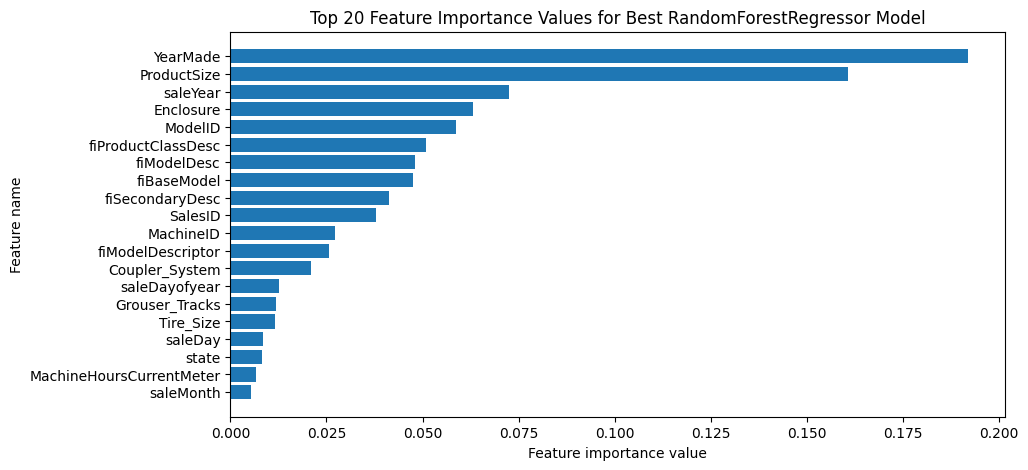

In [146]:
# Plot the top feature importance values
top_n = 20
plt.figure(figsize=(10, 5))
plt.barh(y=feature_importance_df["feature_names"][:top_n], # Plot the top_n feature importance values
         width=feature_importance_df["feature_importance"][:top_n])
plt.title(f"Top {top_n} Feature Importance Values for Best RandomForestRegressor Model")
plt.xlabel("Feature importance value")
plt.ylabel("Feature name")
plt.gca().invert_yaxis();

## Conclusion

The visualization above shows the top 20 most important features used by the Random Forest model. Features like `YearMade`, `saleYear`, and various equipment characteristics contribute most significantly to the model's predictions for bulldozer prices. This feature importance analysis helps us understand which attributes are most influential in determining equipment value.